## Train a Deep Neural Network For Predicting a Stock's Closing Price

This notebook is a guide on training a deep neural network (dnn) to predict a stock's closing price from an algorithm's trading history. The [Analysis Engine](https://github.com/jay-johnson/stock-analysis-engine) makes it easy to roll custom AI training datasets from minute-by-minute, intraday algorithm backtest. Each algorithm backtest automatically publishes its trading history to S3 (Minio or AWS). These trading histories are compressed [pandas DataFrames](http://pandas.pydata.org/pandas-docs/stable/reference/frame.html) where the algorithm's indicator decisions are stored as columns withnin this DataFrame. These columns become training features for a dnn to learn (hopefully).

### How it works

#### Before Running the Notebook

1. Run through [Getting Started with the Analysis Engine](https://github.com/AlgoTraders/stock-analysis-engine#getting-started)

1. Publish a Trading History from an Algoritm's Backtest to S3

#### Getting Started

1. Load the Runtime

1. Set Algorithm's S3 Bucket and Key Values as needed

1. Load the Trading History Dataset from S3

1. Prepare Training Dataset from Trading History
   
   (**This version is only using High + Low + Open without scaler normalization - stay tuned!**)

1. Create the Test and Train Dataset Splits

1. Build and Compile a KerasRegressor using Keras + Tensorflow + Scikit-learn

1. Fit the DNN (train)

1. Determine Error (MSE + MAE + MAPE + CP)

1. Run DNN Predictions

1. Plot Historical Close vs DNN's Predicted Close

The current notebook uses Keras and Tensorflow to build a KerasRegressor.

This regressor is created using a custom layer configuration (json dictionary) that can support Dense and Dropout Keras layer types. After creation it will    

## Load Runtime

In [1]:
import datetime
print(f'starting - {datetime.datetime.now()}')

import copy
import numpy as np
import numpy.random as np_random
import pandas as pd
import pandas.api.types as pandas_types
import sklearn.model_selection as tt_split
import keras.wrappers.scikit_learn as keras_scikit
import tensorflow as tf
import analysis_engine.consts as ae_consts
import analysis_engine.load_history_dataset as load_history
import analysis_engine.ai.build_regression_dnn as build_dnn
import analysis_engine.plot_trading_history as plot_trading_history

print(f'imports done - {datetime.datetime.now()}')

# ensure reproducible results tip from:
# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
np_random.seed(1)

print(f'ready - {datetime.datetime.now()}')

starting - 2019-01-27 02:22:00.785266


Using TensorFlow backend.


imports done - 2019-01-27 02:22:03.685627
ready - 2019-01-27 02:22:03.688396


## Set Algorithm's S3 Bucket and Key Values

In [2]:
# change these to your values:
s3_bucket = (
    f'algohistory')
s3_key = (
    f'algo_training_SPY.json')

s3_access_key = ae_consts.S3_ACCESS_KEY
s3_secret_key = ae_consts.S3_SECRET_KEY
s3_region_name = ae_consts.S3_REGION_NAME
s3_address = ae_consts.S3_ADDRESS
s3_secure = ae_consts.S3_SECURE
compress = True

## Load the Trading History Dataset from S3

In [3]:
load_res = load_history.load_history_dataset(
    s3_enabled=True,
    s3_key=s3_key,
    s3_address=s3_address,
    s3_bucket=s3_bucket,
    s3_access_key=s3_access_key,
    s3_secret_key=s3_secret_key,
    s3_region_name=s3_region_name,
    s3_secure=s3_secure,
    compress=compress)

ticker = None
if 'tickers' not in load_res:
    print(
        f'unable to load trading history from s3://{s3_address}/{s3_bucket}/{s3_key}')
else:
    tickers = load_res.get(
        'tickers',
        [
            'SPY',
        ])
    ticker = tickers[0]
    print(
        f'loaded trading history from s3://{s3_bucket}/{s3_key}')

loaded trading history from s3://algohistory/algo_training_SPY.json


## Prepare Training Dataset from Trading History

In [4]:
df = load_res[ticker]
df['date'] = pd.to_datetime(
    df['date'])
df['minute'] = pd.to_datetime(
    df['minute'])
ticker = df['ticker'].iloc[0]
first_date = df['date'].iloc[0]
end_date = df['date'].iloc[-1]

if 'minute' in df:
    found_valid_minute = df['minute'].iloc[0]
    if found_valid_minute:
        first_date = df['minute'].iloc[0]
        end_date = df['minute'].iloc[-1]

num_rows = len(df.index)

print(
    f'prepared training data from history {s3_bucket}@{s3_key} '
    f'rows={num_rows} '
    f'dates: {first_date} to {end_date}')

"""
for scaler-normalized datasets this will
compile numeric columns and ignore string/non-numeric
columns as training and test feature columns
"""
predict_feature = 'close'
use_all_features = False 
all_features = []
train_features = []
if use_all_features:
    for c in df.columns.values:
        if pandas.api.types.is_numeric_dtype(df[c]):
            if c != predict_feature:
                train_features.append(c)
            all_features.append(c)
else:
    # easier to debug if there's less features to train
    train_features = [
        'high',
        'low',
        'open'
    ]
    all_features = [
        'close'
    ] + train_features

num_features = len(train_features)

prepared training data from history algohistory@algo_training_SPY.json rows=395 dates: 2019-01-18 16:00:00 to 2019-01-25 15:59:00


### Create Deep Neural Network Config

In [5]:
dnn_config = {
    'layers': [
        {
            'num_neurons': 150,
            'init': 'uniform',
            'activation': 'relu'
        },
        {
            'num_neurons': 100,
            'init': 'uniform',
            'activation': 'relu'
        },
        {
            'num_neurons': 50,
            'init': 'uniform',
            'activation': 'relu'
        },
        {
            'num_neurons': 1,
            'init': 'uniform',
            'activation': 'relu'
        }
    ]
}

### Create Keras Compile Config

In [6]:
compile_config = {
    'loss': 'mse',
    'optimizer': 'adam',
    'metrics': [
        'accuracy',
        'mse',
        'mae',
        'mape',
        'cosine'
    ]
}

### Set Prediction Feature

In [7]:
predict_feature = 'close'

### Build Train and Test DataFrames

In [8]:
print(
    f'building train and test dfs')

converted_df = df[all_features].dropna().astype(
    'float32')
train_df = converted_df[train_features]
test_df = converted_df[[predict_feature]]

building train and test dfs


## Build and Compile a KerasRegressor using Keras + Tensorflow + Scikit-learn

In [9]:
use_epochs = 20
use_batch_size = 10
use_test_size = 0.1
use_random_state = 1
use_seed = 7  # change this to random in prod
use_shuffle = False
model_verbose = True
fit_verbose = True

def set_model():
    return build_dnn.build_regression_dnn(
        num_features=num_features,
        compile_config=compile_config,
        model_config=dnn_config)

estimator = keras_scikit.KerasRegressor(
    build_fn=set_model,
    epochs=use_epochs,
    batch_size=use_batch_size,
    verbose=model_verbose)

## Create the Test and Train Dataset Splits

In [10]:
(x_train,
 x_test,
 y_train,
 y_test) = tt_split.train_test_split(
     train_df,
     test_df,
     test_size=use_test_size,
     random_state=use_random_state)

print(
    f'split breakdown - '
    f'x_train={len(x_train)} '
    f'x_test={len(x_test)} '
    f'y_train={len(y_train)} '
    f'y_test={len(y_test)}')

split breakdown - x_train=354 x_test=40 y_train=354 y_test=40


## Fit the DNN (train)

In [11]:
history = estimator.fit(
    x_train,
    y_train,
    validation_data=(
        x_train,
        y_train),
    epochs=use_epochs,
    batch_size=use_batch_size,
    shuffle=use_shuffle,
    verbose=fit_verbose)

Train on 354 samples, validate on 354 samples
Epoch 1/20
354/354 [==============================] - ETA: 10s - loss: 70804.8281 - acc: 0.0000e+00 - mean_squared_error: 70804.8281 - mean_absolute_error: 266.0917 - mean_absolute_percentage_error: 99.9638 - cosine_proximity: -1.000 - ETA: 0s - loss: 67224.0867 - acc: 0.0050 - mean_squared_error: 67224.0867 - mean_absolute_error: 258.5610 - mean_absolute_percentage_error: 89638.2817 - cosine_proximity: -0.9950  - 0s 1ms/step - loss: 54972.0017 - acc: 0.0113 - mean_squared_error: 54972.0017 - mean_absolute_error: 229.6648 - mean_absolute_percentage_error: 1336357.7580 - cosine_proximity: -0.9887 - val_loss: 8709.5013 - val_acc: 0.0113 - val_mean_squared_error: 8709.5013 - val_mean_absolute_error: 92.7989 - val_mean_absolute_percentage_error: 3012164.1780 - val_cosine_proximity: -0.9887
Epoch 2/20
354/354 [==============================] - ETA: 0s - loss: 8819.7578 - acc: 0.0000e+00 - mean_squared_error: 8819.7578 - mean_absolute_error: 93.9

Epoch 12/20
354/354 [==============================] - ETA: 0s - loss: 0.0016 - acc: 0.1000 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0334 - mean_absolute_percentage_error: 0.0126 - cosine_proximity: -1.000 - ETA: 0s - loss: 0.0032 - acc: 0.0364 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0385 - mean_absolute_percentage_error: 1817756.7408 - cosine_proximity: -0.995 - 0s 333us/step - loss: 0.0041 - acc: 0.0311 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0398 - mean_absolute_percentage_error: 4518417.6391 - cosine_proximity: -0.9887 - val_loss: 0.0041 - val_acc: 0.0311 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0394 - val_mean_absolute_percentage_error: 4518320.4638 - val_cosine_proximity: -0.9887
Epoch 13/20
354/354 [==============================] - ETA: 0s - loss: 0.0017 - acc: 0.1000 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0342 - mean_absolute_percentage_error: 0.0129 - cosine_proximity: -1.000 - ETA: 0s - loss: 0.0033

## Determine Error (MSE + MAE + MAPE + CP)

In [12]:
mse_err = None
mae_err = None
mape_err = None
cp_err = None
if len(history.history['mean_squared_error']) > 0:
    mse_err = ae_consts.to_f(
        history.history['mean_squared_error'][0])
if len(history.history['mean_absolute_error']) > 0:
    mae_err = ae_consts.to_f(
        history.history['mean_absolute_error'][0])
if len(history.history['mean_absolute_percentage_error']) > 0:
    mape_err = ae_consts.to_f(
        history.history['mean_absolute_percentage_error'][0])
if len(history.history['cosine_proximity']) > 0:
    cp_err = ae_consts.to_f(
        history.history['cosine_proximity'][0])

error_str = (
    f'MSE: {mse_err} '
    f'MAE: {mae_err} '
    f'MAPE: {mape_err} '
    f'CP: {cp_err}')

print(error_str)

MSE: 54972.0 MAE: 229.66 MAPE: 1336357.76 CP: -0.99


## Build Predictions

In [13]:
# on production use newly fetched pricing data
# not the training data
predict_records = df[train_features]

## Run Predictions

In [14]:
print(
    f'making predictions: {len(predict_records)}')

predictions = estimator.model.predict(
    predict_records,
    verbose=True)

np.set_printoptions(threshold=np.nan)
indexes = tf.argmax(predictions, axis=1)
data = {}
data['indexes'] = indexes
price_predictions = [ae_consts.to_f(x[0]) for x in predictions]

df['predicted_close'] = price_predictions
df['error'] = (
    df['close'] -
    df['predicted_close'])
average_error = ae_consts.to_f(
    df['error'].sum() / len(df.index))

output_features = [
    'minute',
    'close',
    'predicted_close',
    'error'
]

df_filter = (df['close'] >= 0.1)
date_str = (
    f'Dates: {df[df_filter]["minute"].iloc[0]} '
    f'to '
    f'{df[df_filter]["minute"].iloc[-1]}')

print(
    f'historical close with predicted close: '
    f'{df[df_filter][["minute", "close", "predicted_close"]]}')
print(
    date_str)
print(
    f'Columns: {output_features}')
print(
    f'Average historical close '
    f'vs predicted close error: '
    f'{average_error}')

making predictions: 395
395/395 [==============================] - ETA:  - 0s 114us/step
historical close with predicted close:                  minute   close  predicted_close
5   2019-01-25 09:30:00  265.53           265.58
6   2019-01-25 09:31:00  265.36           265.49
7   2019-01-25 09:32:00  265.32           265.38
8   2019-01-25 09:33:00  265.45           265.42
9   2019-01-25 09:34:00  265.32           265.31
10  2019-01-25 09:35:00  265.26           265.23
11  2019-01-25 09:36:00  265.35           265.29
12  2019-01-25 09:37:00  265.22           265.30
13  2019-01-25 09:38:00  265.22           265.24
14  2019-01-25 09:39:00  265.23           265.25
15  2019-01-25 09:40:00  265.39           265.32
16  2019-01-25 09:41:00  265.42           265.42
17  2019-01-25 09:42:00  265.22           265.23
18  2019-01-25 09:43:00  265.34           265.25
19  2019-01-25 09:44:00  265.27           265.33
20  2019-01-25 09:45:00  265.28           265.33
21  2019-01-25 09:46:00  265.32        

## Plot Historical Close vs DNN's Predicted Close

plotting historical close vs predicted close


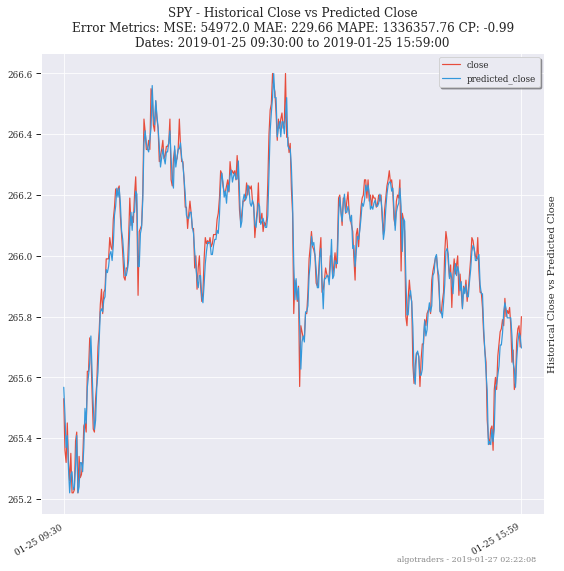

In [15]:
print(
    f'plotting historical close vs predicted close')

plot_res = plot_trading_history.plot_trading_history(
    title=(
        f'{ticker} - Historical Close vs Predicted Close\n'
        f'Error Metrics: {error_str}\n'
        f'{date_str}'),
    df=copy.deepcopy(df),
    red='close',
    blue='predicted_close',
    green=None,
    orange=None,
    date_col='minute',
    date_format='%d %H:%M:%S\n%b',
    xlabel='minute',
    ylabel='Historical Close vs Predicted Close',
    df_filter=df_filter,
    width=8.0,
    height=8.0,
    show_plot=True,
    dropna_for_all=False)